Source: Sheldon Coup (MSc, UC)

# Importing needed libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

import tensorflow as tf

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
#from tf.keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
# from keras.wrappers.scikit_learn import KerasClassifier

# Utility functions

In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Main section

We will be using the MNIST dataset, which is built into Keras.
[MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


First of all we need to know what the size of the data we are dealing with is. \\
x_train, y_train, x_test and y_test are all numpy arrays, so we can just have a look at the shape attribute of each of them.
[More info on Numpy](https://www.numpy.org/)

In [4]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


This shows that we have 28 * 28 dimensional images with 60000 training images and 10000 testing images. \\
Next, in order to use a fully connected network to classify the images we need to convert these 28 * 28 images into vectors. \\
This can be done easily using the reshape function in numpy. [See this manual for more information of reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) \\
Additionally, as the inputs are images, we will rescale the vector values to be between 0 and 1 (rather than between 0 and 255). It will help our models to learn.

In [5]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


The final step in the data preparation is to convert the integer labels (target labels, what we want to predict) to one-hot encoded labels. \\
We convert labels "0", "1",...,"9" into vectors 1000000, 0100000,...,0000001. \\
Keras has a built in function that does this named to_categorical. \\
Be careful here, if you run this section of code more than once then you might one-hot-encode your one-hot-encoded labels!

In [6]:
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)


Next we want to initialize our neural network model. \\
We start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers. \\
Here we will be starting with a simple network with just a single hidden layer with 32 neurons. \\
Make sure you set the size of the output layer to be the number of classes that we are trying to predict! \\
We can have a look at out model using the model.summary() function.

In [7]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

Before training we must compile out model and select three important things:

1.   Paramaters of  optimisitation procedure to use. For now we will be using simple SGD - gradient descent, this optimizer is the first one to ever be used in practice and the most simple to understand. By default in Keras, SGD is a gradient descent  with a fixed learning rate.
There are lots of other options for optimisation that we could look at though, for example using adaptive learning rate RMSprop, Adam, Adadelta, etc

2.   What loss function to use. For classification this loss function is almost always 'categorical_crossentropy', but if we were doing regression then we would be using a different loss function. Which one?

3. Finally, a metric. Generally, for classification, we are looking at the accuracy of the model. However we could also look at things like top k accuracy.


In [8]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

Finally, we are able to train our model to do some classification. Here we must select how long we wish to train for (epochs) and the mini-batch size.

In [9]:

history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2197 - loss: 2.2670 - val_accuracy: 0.6307 - val_loss: 1.9374
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6372 - loss: 1.8717 - val_accuracy: 0.7322 - val_loss: 1.6180
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7136 - loss: 1.5776 - val_accuracy: 0.7853 - val_loss: 1.3521
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7552 - loss: 1.3369 - val_accuracy: 0.8198 - val_loss: 1.1460
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7851 - loss: 1.1554 - val_accuracy: 0.8382 - val_loss: 0.9907


Test loss: 1.02
Test accuracy: 0.813


<Figure size 800x600 with 0 Axes>

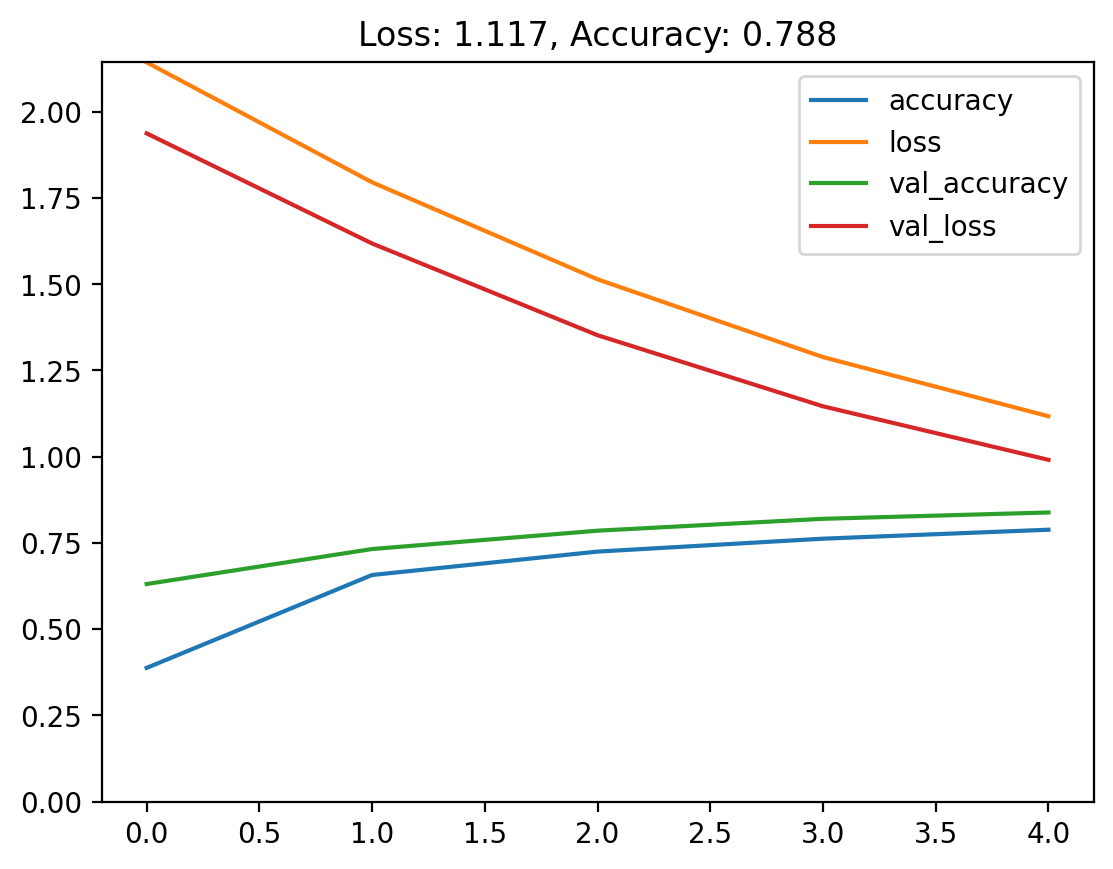

In [10]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Clearly we can see that our model was getting better during training but didn't have enough time to reach its full potential! Let's restart and train it for a bit longer and see if we can get better results.


In [11]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2956 - loss: 2.2274 - val_accuracy: 0.6358 - val_loss: 1.9022
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6346 - loss: 1.8305 - val_accuracy: 0.7247 - val_loss: 1.5667
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7027 - loss: 1.5325 - val_accuracy: 0.7810 - val_loss: 1.3080
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7487 - loss: 1.3011 - val_accuracy: 0.8110 - val_loss: 1.1145
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7815 - loss: 1.1286 - val_accuracy: 0.8403 - val_loss: 0.9694
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8040 - loss: 0.9979 - val_accuracy: 0.8577 - val_loss: 0.8580
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8206 - loss: 0.8952 - val_accuracy: 0.8693 - val_loss: 0.7714
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8305 - loss: 0.8231 - val_accuracy: 0.

Let's see what the loss and accuracy curves look like.

<Figure size 800x600 with 0 Axes>

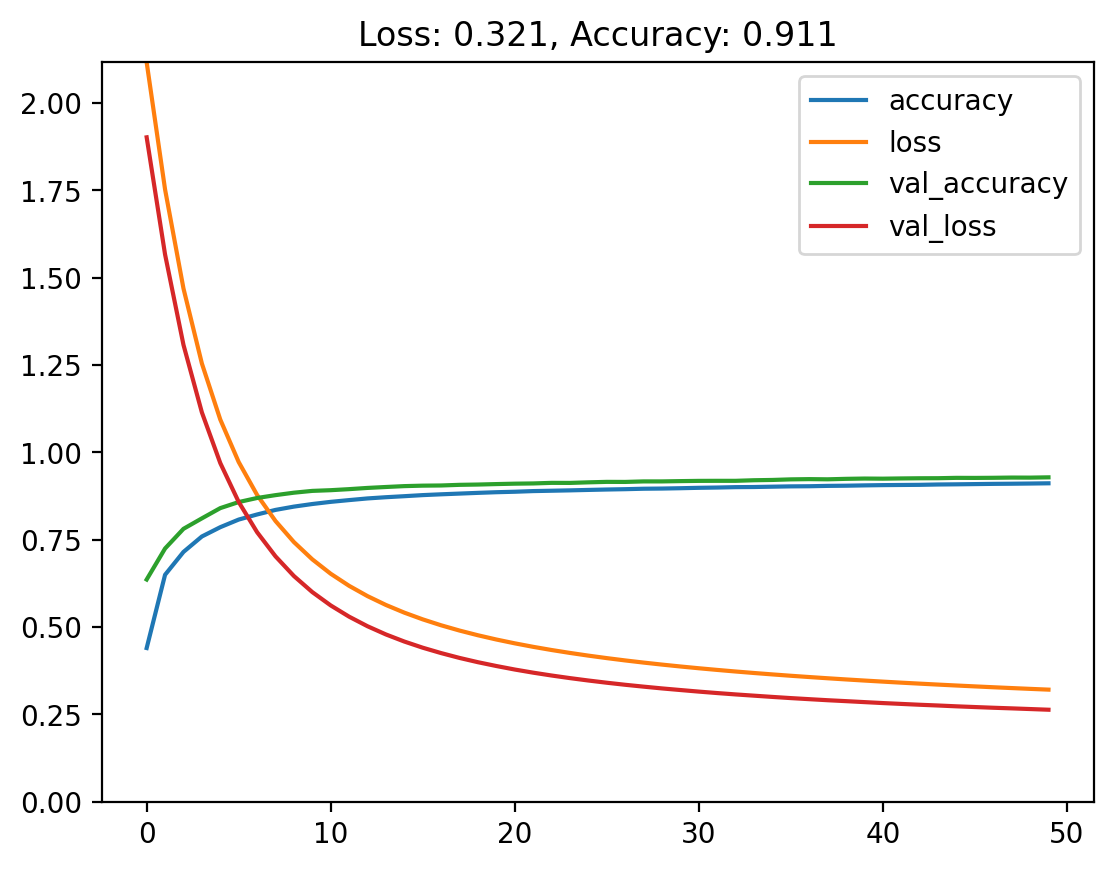

In [12]:
plot_loss_accuracy(history)

That's looking a bit better. Now we can test this trained model on our test set to get the final test result.

In [13]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.304
Test accuracy: 0.917


Now lets try out *batch* training, where we train using the entire training set each step.

In [14]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0752 - loss: 2.3754 - val_accuracy: 0.0672 - val_loss: 2.3757
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step - accuracy: 0.0752 - loss: 2.3731 - val_accuracy: 0.0675 - val_loss: 2.3734
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - accuracy: 0.0753 - loss: 2.3709 - val_accuracy: 0.0675 - val_loss: 2.3712
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.0755 - loss: 2.3687 - val_accuracy: 0.0677 - val_loss: 2.3690
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.0756 - loss: 2.3665 - val_accuracy: 0.0680 - val_loss: 2.3669
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.0761 - loss: 2.3643 - val_accuracy: 0.0682 - val_loss: 2.3648
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.0763 - loss: 2.3622 - val_accuracy: 0.0685 - val_loss: 2.3627
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.0767 - loss: 2.3601 - val_accuracy: 0.0690 - val_loss: 2.

<Figure size 800x600 with 0 Axes>

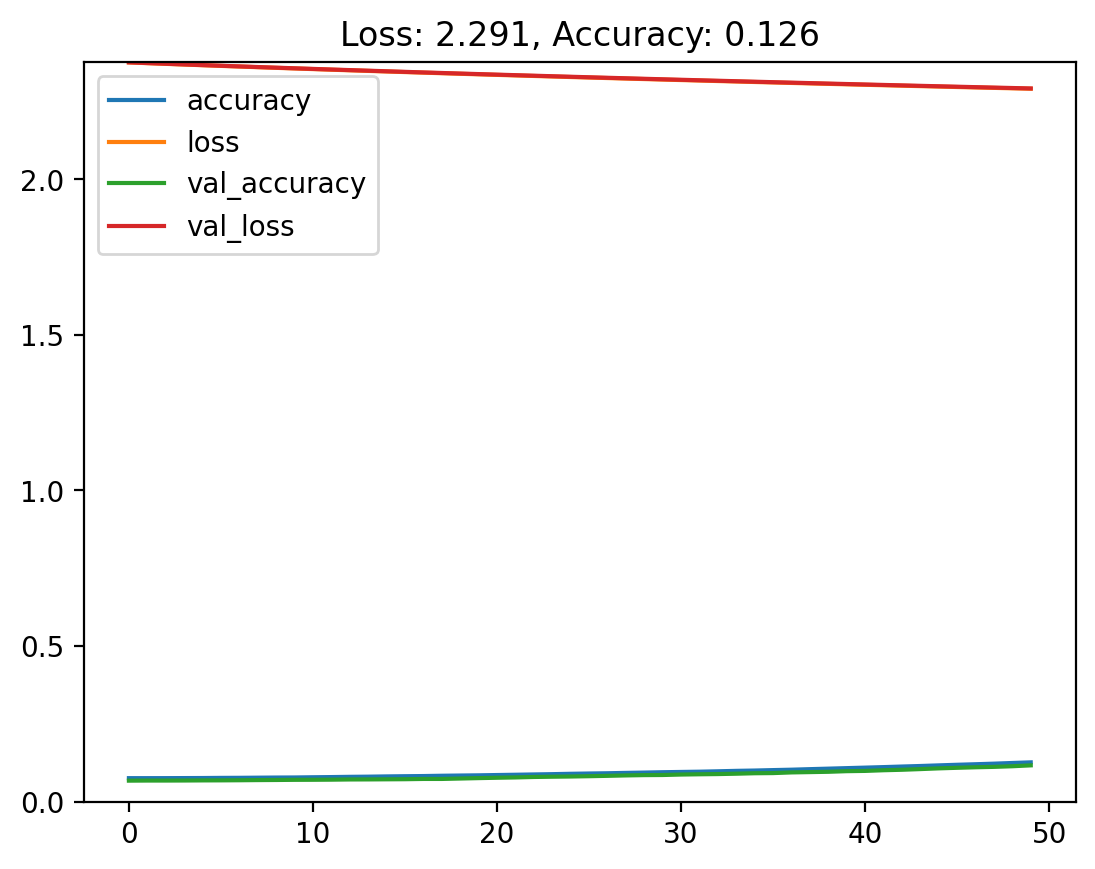

In [15]:
plot_loss_accuracy(history)

Notice how the loss function is reduced much less per each epoch in comparison with  the mini-batch gradient descent.  It's because we update gradient only once per epoch  in batch training but we update it 54000/128=421 times per epoch in the case of mini-batch gradient descent. You will also see that the loss function might look a bit jittery for the mini-batch case. This is because we estimate gradient, and each iteration we might have slightly different estimate \\
Using the whole dataset at each step seems to be converging a bit slower than we would like and we don't have all day to wait around for things to train, so lets try restarting using a increased learning rate.

The default SGD learning rate is 0.01

In [16]:
model = build_basic_model()
model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0972 - loss: 2.5057 - val_accuracy: 0.1007 - val_loss: 2.4448
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.1003 - loss: 2.4527 - val_accuracy: 0.1135 - val_loss: 2.4037
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - accuracy: 0.1128 - loss: 2.4110 - val_accuracy: 0.1278 - val_loss: 2.3700
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1249 - loss: 2.3767 - val_accuracy: 0.1392 - val_loss: 2.3417
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.1350 - loss: 2.3479 - val_accuracy: 0.1518 - val_loss: 2.3174
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1435 - loss: 2.3234 - val_accuracy: 0.1643 - val_loss: 2.2964
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.1530 - loss: 2.3021 - val_accuracy: 0.1795 - val_loss: 2.2780
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.1687 - loss: 2.2834 - val_accuracy: 0.2030 - val_loss: 2.

<Figure size 800x600 with 0 Axes>

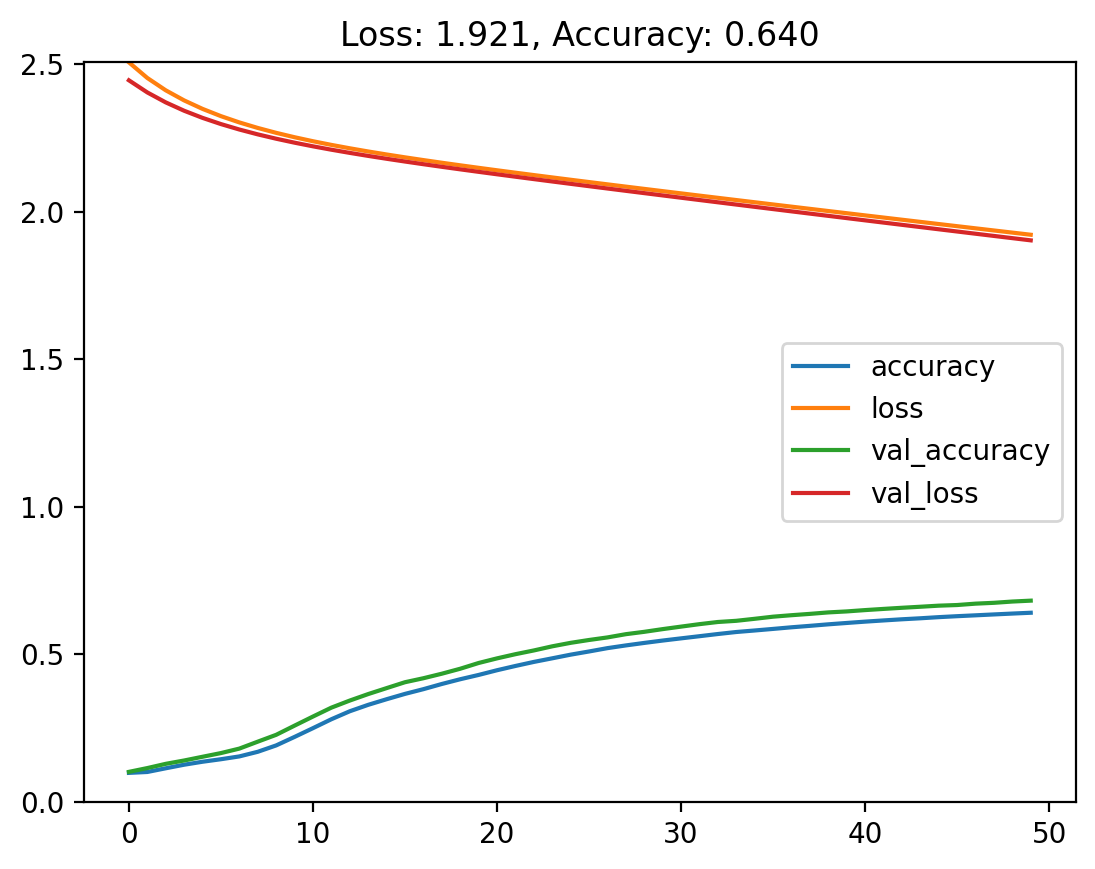

In [17]:
plot_loss_accuracy(history)

In [18]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 1.9
Test accuracy: 0.656


That is an improvement, but what if we move past a simple fixed learning rate like  in the SGD optimizer. Lets have a look at Adam method.
We are going to take the batch size back down to 256 now, feel free to experiment and put your own batch size in.

In [19]:
model = build_basic_model()
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5084 - loss: 1.7819 - val_accuracy: 0.8818 - val_loss: 0.7483
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8654 - loss: 0.6991 - val_accuracy: 0.9135 - val_loss: 0.4270
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8984 - loss: 0.4544 - val_accuracy: 0.9268 - val_loss: 0.3231
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9114 - loss: 0.3596 - val_accuracy: 0.9325 - val_loss: 0.2727
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9189 - loss: 0.3159 - val_accuracy: 0.9392 - val_loss: 0.2433
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9264 - loss: 0.2811 - val_accuracy: 0.9420 - val_loss: 0.2229
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9304 - loss: 0.2585 - val_accuracy: 0.9457 - val_loss: 0.2061
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9362 - loss: 0.2395 - val_accuracy: 0.

<Figure size 800x600 with 0 Axes>

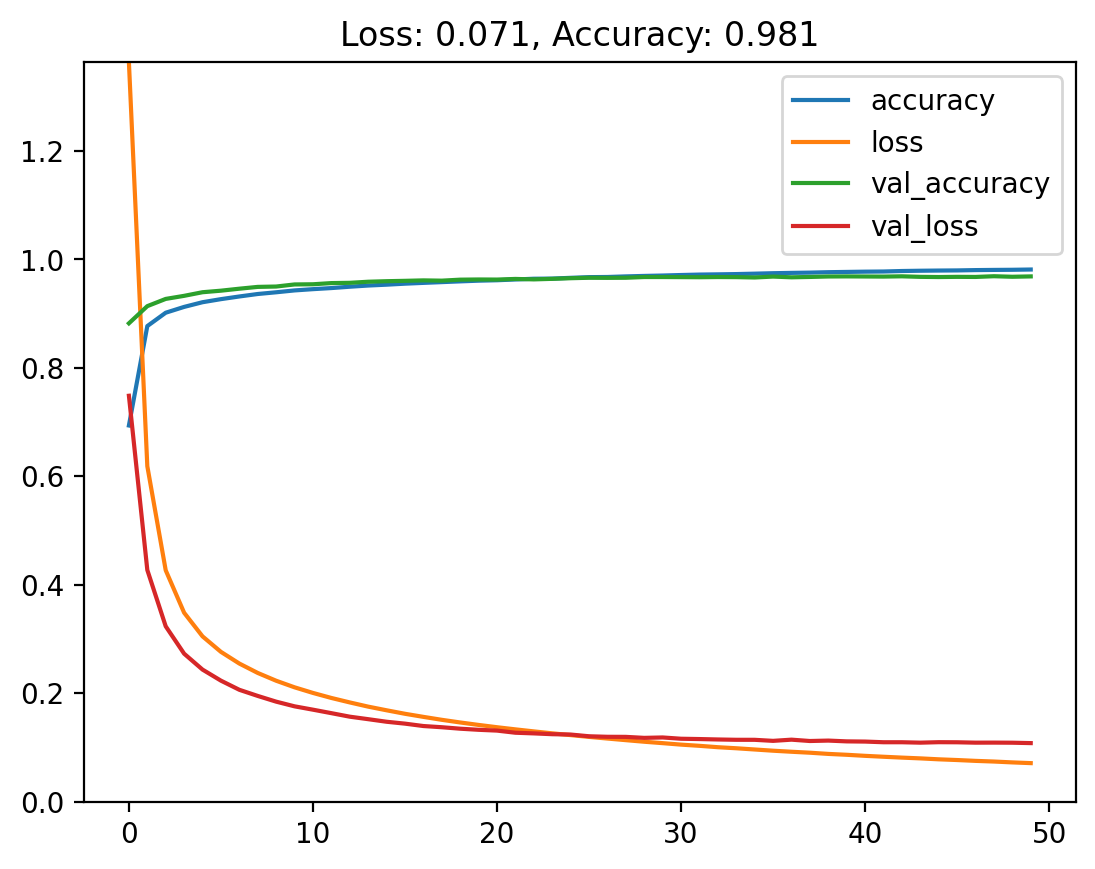

In [20]:
plot_loss_accuracy(history)

In [21]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.126
Test accuracy: 0.961


That works quite well, Adam allows for more complex learning rate updates than in the SGD optimizer.  It's used frequently in practise.
What if we bump up the starting learning rate on this Adam optimizer?
Note the learning rate value must be written as a decimal (float).



In [23]:
model = build_basic_model()
model.compile(tf.keras.optimizers.Adam(learning_rate=5.0), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3085 - loss: 15.6534 - val_accuracy: 0.5505 - val_loss: 1.6389
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4950 - loss: 1.5880 - val_accuracy: 0.4862 - val_loss: 1.4572
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4745 - loss: 1.7360 - val_accuracy: 0.3098 - val_loss: 2.1291
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3682 - loss: 3.0643 - val_accuracy: 0.4452 - val_loss: 1.6473
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4550 - loss: 1.8624 - val_accuracy: 0.4335 - val_loss: 2.0452
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4060 - loss: 2.0231 - val_accuracy: 0.4205 - val_loss: 1.8735
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4435 - loss: 1.8201 - val_accuracy: 0.6008 - val_loss: 1.2681
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5321 - loss: 1.4416 - val_accuracy: 0

<Figure size 800x600 with 0 Axes>

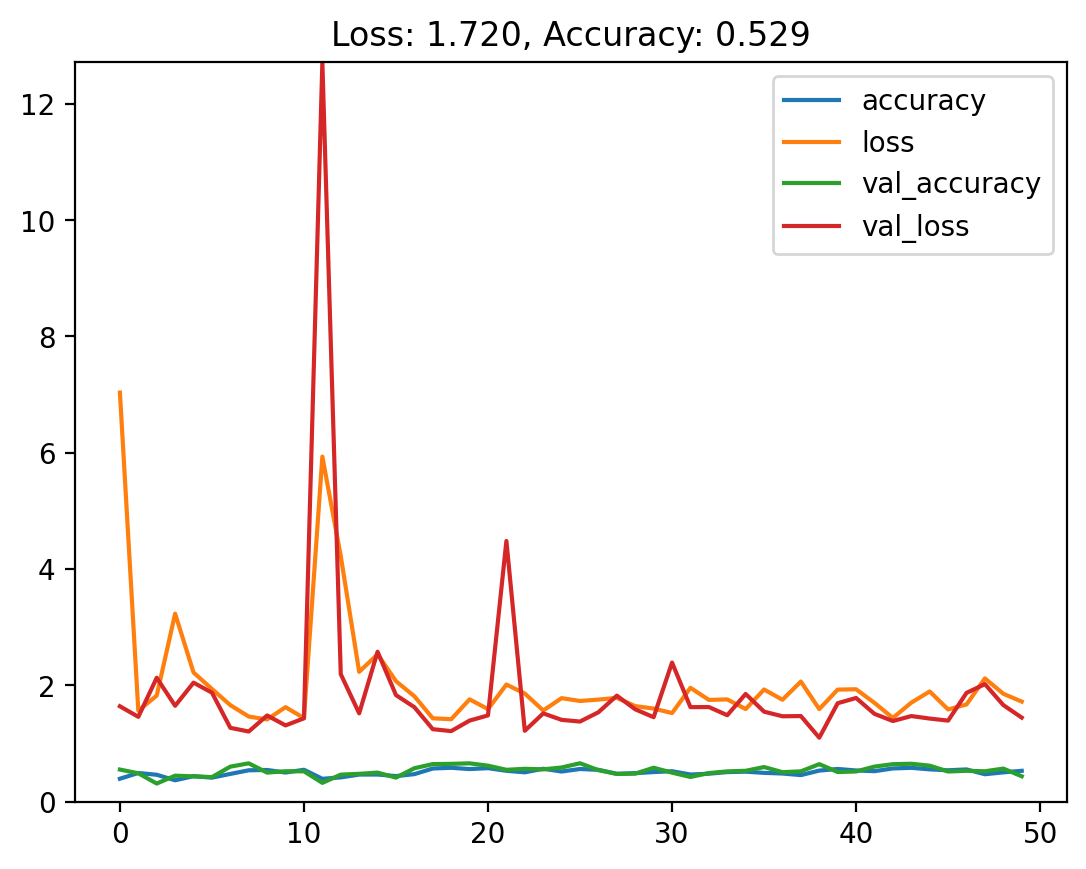

In [24]:
plot_loss_accuracy(history)

So this is the other end of the scale when it comes to tuning learning rates, this is far too high and the model is actually getting worse during training. We want models to train as quickly as possible so we don't waste our time, but if we get overzealous and set the learning rate too high we might not be able to train at all! Usually we can tell from the loss curve when this is the case though.

Lets try using an optimizer with momentum - it's almost like Adam, it still adapts learning rate in the course of training but with a bit of twist. We will be using the 'Nadam ' optimizer here
Nadam = N(esterov momentum) Adam

In [25]:
model = build_basic_model()
model.compile('nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5320 - loss: 1.7388 - val_accuracy: 0.8898 - val_loss: 0.7275
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8692 - loss: 0.6842 - val_accuracy: 0.9147 - val_loss: 0.4246
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8971 - loss: 0.4533 - val_accuracy: 0.9257 - val_loss: 0.3231
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9069 - loss: 0.3667 - val_accuracy: 0.9333 - val_loss: 0.2749
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9180 - loss: 0.3165 - val_accuracy: 0.9398 - val_loss: 0.2444
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9235 - loss: 0.2856 - val_accuracy: 0.9435 - val_loss: 0.2246
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9278 - loss: 0.2655 - val_accuracy: 0.9462 - val_loss: 0.2094
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9331 - loss: 0.2428 - val_accuracy: 0.

Test loss: 0.126
Test accuracy: 0.963


<Figure size 800x600 with 0 Axes>

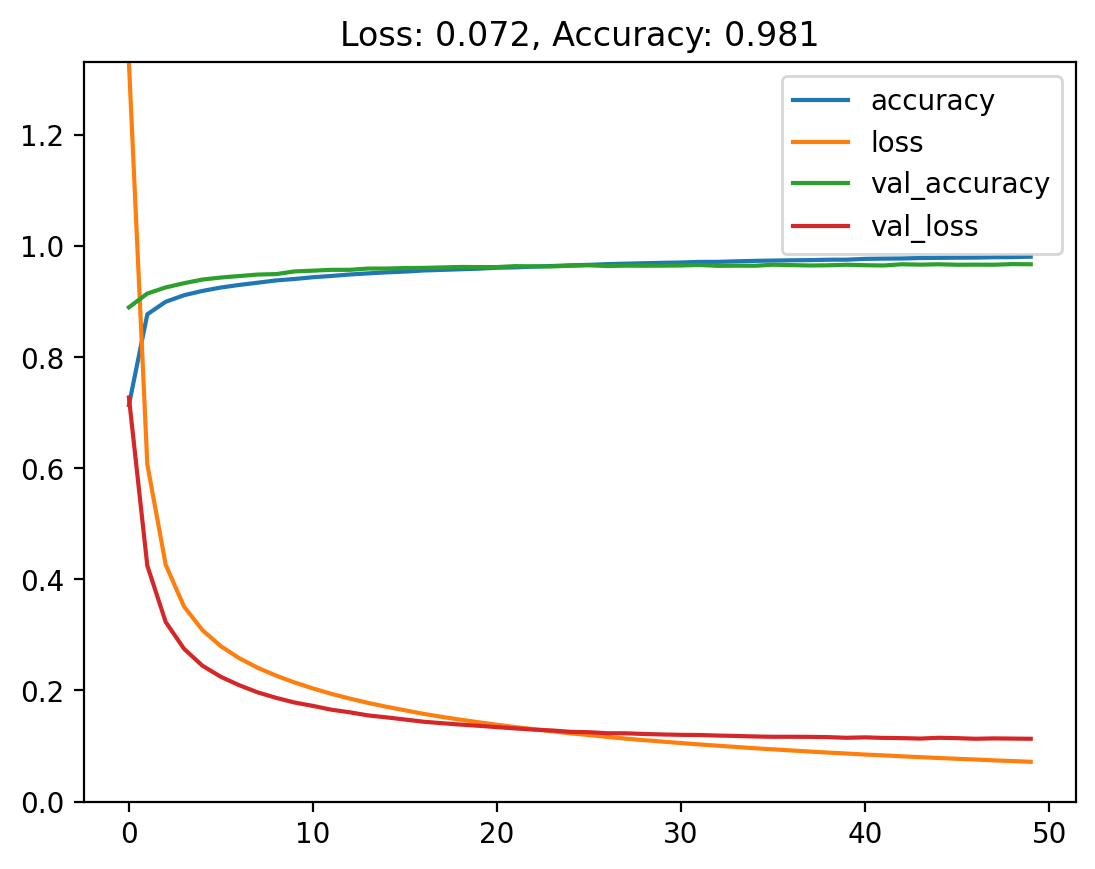

In [26]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

All of these models have *in general* converged to ~92 % accuracy. This gives an indication that this is likely to be the maximum capacity of the neural network structure that we have constructed. Considering that this model has just one hidden layer, it is getting pretty solid performance. Lets try  to experiment with a model that is a little bit more complex and see if we can get a little bit higher performance.
One thing to note about creating more complex models is the seriously diminishing returns, in most cases each new layer you add with contribute less to the performance than previous layers. I.e the difference between a 1 and 2 layer model is much bigger than the difference between a 10 and 11 layer model.


Below I have provided two functions, one creates a model with an additional layer, one has a dropout layer in it. Select an optimizer, learning rate and batch size and see if you can beat any of the test accuracies that we managed to get above.

In [27]:
def build_dropout_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.2))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=64, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=32, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model



In [28]:
opt_dict = {'nadam':tf.keras.optimizers.Nadam,
            'adam':tf.keras.optimizers.Adam,
            'sgd':tf.keras.optimizers.SGD,
            'rmsprop':tf.keras.optimizers.RMSprop,
            'adadelta':tf.keras.optimizers.Adadelta,
            'adagrad':tf.keras.optimizers.Adagrad}

If you want to know what the default learning rate values are for the optimizers have a look here: https://keras.io/optimizers/

In [32]:
model = build_dropout_model()
# or
model = build_deeper_model()
# or make your own model! (recommended)

# set all the following values yourself!
optimizer_name  = 'nadam' # any of the following: nadam, adam, sgd, rmsprop, adadelta, adagrad
my_learning_rate = 0.001 # some number
batch_size = 256 #some integer
training_epochs = 20 # some integer


# selects optimizer and sets learning rate
optimizer = opt_dict[optimizer_name](learning_rate=my_learning_rate)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs, verbose=True, validation_split=.1)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4865 - loss: 1.9004 - val_accuracy: 0.8782 - val_loss: 0.8384
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8645 - loss: 0.7399 - val_accuracy: 0.9160 - val_loss: 0.4199
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9028 - loss: 0.4298 - val_accuracy: 0.9290 - val_loss: 0.2981
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9176 - loss: 0.3248 - val_accuracy: 0.9390 - val_loss: 0.2404
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9281 - loss: 0.2687 - val_accuracy: 0.9468 - val_loss: 0.2064
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9359 - loss: 0.2391 - val_accuracy: 0.9547 - val_loss: 0.1828
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9429 - loss: 0.2083 - val_accuracy: 0.9577 - val_loss: 0.1665
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9502 - loss: 0.1850 - val_accuracy: 0.

Test loss: 0.103
Test accuracy: 0.969


<Figure size 800x600 with 0 Axes>

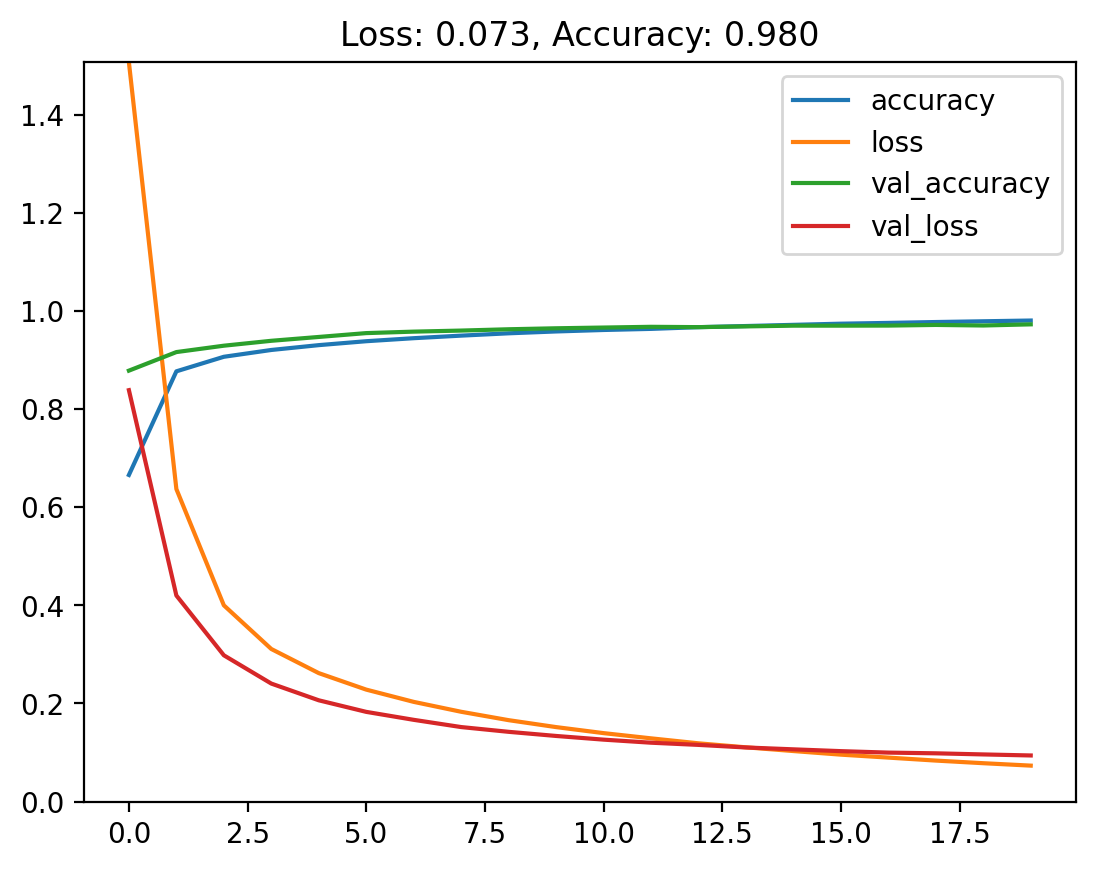

In [33]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')